**Classification of pattern sequences to similar groups - Softmax Regression (Classification) as Multi-layer Perceptron in TensorFlow 2**

This neural network is designed to classify organizational patterns / pattern languages or organizational pattern sequences. Index of a prediction from a Softmax regression with a highest probability is your classified organizational pattern. Our task was to find whether we can calculate probabilities (likelihood) of the organizational patterns based on the frequencies of the words with which they have been documented.

This work is a continuation of the research of Waseeb et al.: Extracting Relations Between Organizational Patterns Using Association Mining, which you can find here: http://www2.fiit.stuba.sk/~vranic/pub/ExtractingRelations.pdf . Dataset we're working on is similar to one page 4. Table 1 titled as "A matrix sample values for n-gram existence against org. patterns".

Sample dataset with frequencies of the 11 bigrams found in textual descriptions of the organizational patterns from http://www.orgpatterns.com/ has been provided.

Example:

Train dataset consists of the frequencies of the bigrams for 18 organizational patterns. Output from this Artificial Neural Network is vector for a pattern with frequencies from a validation and test dataset with as many components as patterns in training dataset. 

(x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11, x12, x13, x14, x15, x16, x17, x18)

where xi is output from a softmax regression and it's a likelihood of the pattern given observed frequencies.
Biggest value - highest probability from this vector is a classification of the set of the bigram frequencies to a given pattern.

**Main Idea**

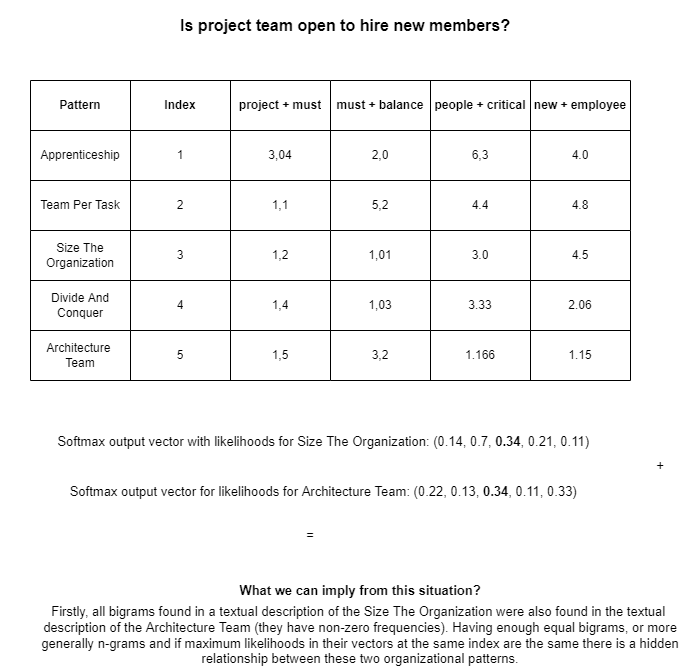

Training test and validation datasets consist of the same 11 bigrams, or attributes. Validation dataset should be used to optimalize hyperparameters (parameters which are not trained during computation of this ANN) and test dataset shall be used only once.

Please note that prediction is correct if it is consistent with an actual class. Accuracy of the model is one of the metrics used to evaluate this behavior.

Theory behind this can be found in a book Dive into Deep Learning: https://d2l.ai/chapter_linear-networks/softmax-regression.html

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import categorical_crossentropy
from keras.utils.np_utils import to_categorical
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

tf.keras.backend.clear_session()

train_df = pd.read_excel('bigram-pattern-frequencies-train.xlsx', engine='openpyxl')
val_df = pd.read_excel('bigram-pattern-frequencies-val.xlsx', engine='openpyxl')
test_df = pd.read_excel('bigram-pattern-frequencies-test.xlsx', engine='openpyxl')

**Normalization of organizational patterns bigram frequencies**

Why? Because some of the bigrams (independent variables, attributes X) have higher frequencies than the others. This means they are used often in pattern descriptions than those used lest. We will normalize these attributes so they contribute equally to the model training process. Normalization is often a must be to get acceptable results from machine learning or deep learning models.

Because some of the bigrams are used more often than the others they differ in a (statistical) variance. This means they must be normalized because of this fact too. It's not very good to increase learning rate (as one of the hyperparameters of this neural network) when attributes are not normalized before. This could lead to divergency, when we wouldn't be able to find best parameters from this training process.

Good news is we don't have to weigth our labels (indexes representing organizational patterns) since each class (organizational pattern) is represent once in our working dataset.

In [10]:
number_of_patterns = 19

train_scaler = StandardScaler()
train_without_target = train_df.drop(['PatternIndex'], axis=1)
train_without_pattern_name = train_without_target.drop(['OrganizationalPattern'], axis=1)
train_features = train_scaler.fit(train_without_pattern_name.values)

X_train = pd.DataFrame(train_scaler.transform(train_df.iloc[:, 1:-1].values))
y_train = to_categorical(train_df.iloc[:,-1].values, number_of_patterns) # hot-encoding label (pattern index) for softmax regression

val_scaler = StandardScaler()
val_without_target = val_df.drop(['PatternIndex'], axis=1)
val_without_pattern_name = val_without_target.drop(['OrganizationalPattern'], axis=1)
val_features = val_scaler.fit(val_without_pattern_name.values)

X_val = pd.DataFrame(val_scaler.transform(val_df.iloc[:, 1:-1].values))
y_val = to_categorical(val_df.iloc[:,-1].values, number_of_patterns)

test_scaler = StandardScaler()
test_without_target = test_df.drop(['PatternIndex'], axis=1)
test_without_pattern_name = test_without_target.drop(['OrganizationalPattern'], axis=1)
test_features = test_scaler.fit(test_without_pattern_name.values)

X_test = pd.DataFrame(test_scaler.transform(test_df.iloc[:, 1:-1].values))
y_test = to_categorical(test_df.iloc[:,-1].values, number_of_patterns)  

**Softmax Regression - Classification of the patterns based on the n-gram frequencies**

These functions are those components in neural network which are responsible for output generation. Combination of linear functions (layers of the ANN without these functions perform affine transformations only) is stil a linear function. That's why we need non-linear activation function. Non-linear activation functions help us to take advantage of the GPU processing capabilities.

ReLU is one of the standard activation functions used in the neural networks. Softmax is activation function too. Number passed as argument to the constructor of the layer of our Artificial Neural Network is number of perceptrons on this layer. Dropout layer is used as regularization technique to eliminate overfitting of the model on training dataset.

First dense layer is our input layer, or layer to consume our dataset. It has 11 neurons, because we have 11 bigrams in our training dataset. Last layer is output layer of this neural network. All layers between are hidden layers of this network. All layers are fully connected layers of this Multi-layer perceptron.

What we're doing here? Well, we go through these steps for 100 epochs:

 1. we pass here our dataset
 2. we declare ANN as MLP. See https://d2l.ai/chapter_multilayer-perceptrons/index.html
 3. we declare optimizer which we want to use. It's Adam, best in class: https://arxiv.org/pdf/1412.6980.pdf
 4. we work with-minibatches. So we optimalize our parameters after passing each 4 rows in our dataset.
 5. we perform forward pass through this network. This means we generate predictions.
 6. then we compute loss of our prediction
 7. we propagade back this loss through all the layers of this ANN. This is oficial name. But we propagate gradients.
 8. Then we use these updates parameters for another forward pass of this MLP.

At the end we use one of the standards visualization techniques for model evaluation.

In [11]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(11, activation="relu"),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(19, activation="softmax")
])


model.compile(optimizer='adam',
                loss=categorical_crossentropy,
                metrics=["accuracy"])

BATCH_SIZE = 4
EPOCHS = 100
SHUFFLE = True

model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data = (X_val, y_val), shuffle=SHUFFLE)

Epoch 1/100
5/5 [==============================] - 1s 44ms/step - loss: 2.9553 - accuracy: 0.0000e+00 - val_loss: 2.9296 - val_accuracy: 0.1429
Epoch 2/100
5/5 [==============================] - 0s 12ms/step - loss: 2.9576 - accuracy: 0.0556 - val_loss: 2.9278 - val_accuracy: 0.0000e+00
Epoch 3/100
5/5 [==============================] - 0s 8ms/step - loss: 2.9580 - accuracy: 0.1111 - val_loss: 2.9264 - val_accuracy: 0.0000e+00
Epoch 4/100
5/5 [==============================] - 0s 8ms/step - loss: 2.9196 - accuracy: 0.0000e+00 - val_loss: 2.9227 - val_accuracy: 0.0000e+00
Epoch 5/100
5/5 [==============================] - 0s 8ms/step - loss: 2.9311 - accuracy: 0.1111 - val_loss: 2.9162 - val_accuracy: 0.0000e+00
Epoch 6/100
5/5 [==============================] - 0s 8ms/step - loss: 2.9353 - accuracy: 0.0556 - val_loss: 2.9120 - val_accuracy: 0.0000e+00
Epoch 7/100
5/5 [==============================] - 0s 8ms/step - loss: 2.8834 - accuracy: 0.2778 - val_loss: 2.9103 - val_accuracy: 0.00

We still have a low accuracy (bias) mostly because we still deal with a very small dataset. Loss here is a value of the cost function (losses for all predictions). Val_loss is a model variance.

Because loss is lower than the validation loss (but not significantly) we can say our probability prediction model is overfitting. This is why we have employed one of the regularization techniques for neural networks - we added Dropout layer. Documentation for this approach can be found in the work of Srivastava et al. Dropout - A Simple Way to Prevent Neural Networks from Overfitting which you can find here https://jmlr.org/papers/v15/srivastava14a.html

**Aritificial Neural Network evaluation**

Now we have to evaluate our classification model. Non-overfitting softmax regression model for us is a model with roughly same accuracy on the training, validation and test dataset. Visualization through the confusion matrix will help us evaluate model performance on these three types of the data sets.

So now we're going to check our classification accuracy on the training dataset. For evaluation we use a confusion matrix. Confusion matrix consists from the ones and zeros because each organizational pattern in a dataset is represented only once. This could be changed by using other pattern descriptions, from numerous sources but for the same patterns. Ones are visible at those places, where model classified pattern according to n-gram frequencies.

<class 'numpy.ndarray'>


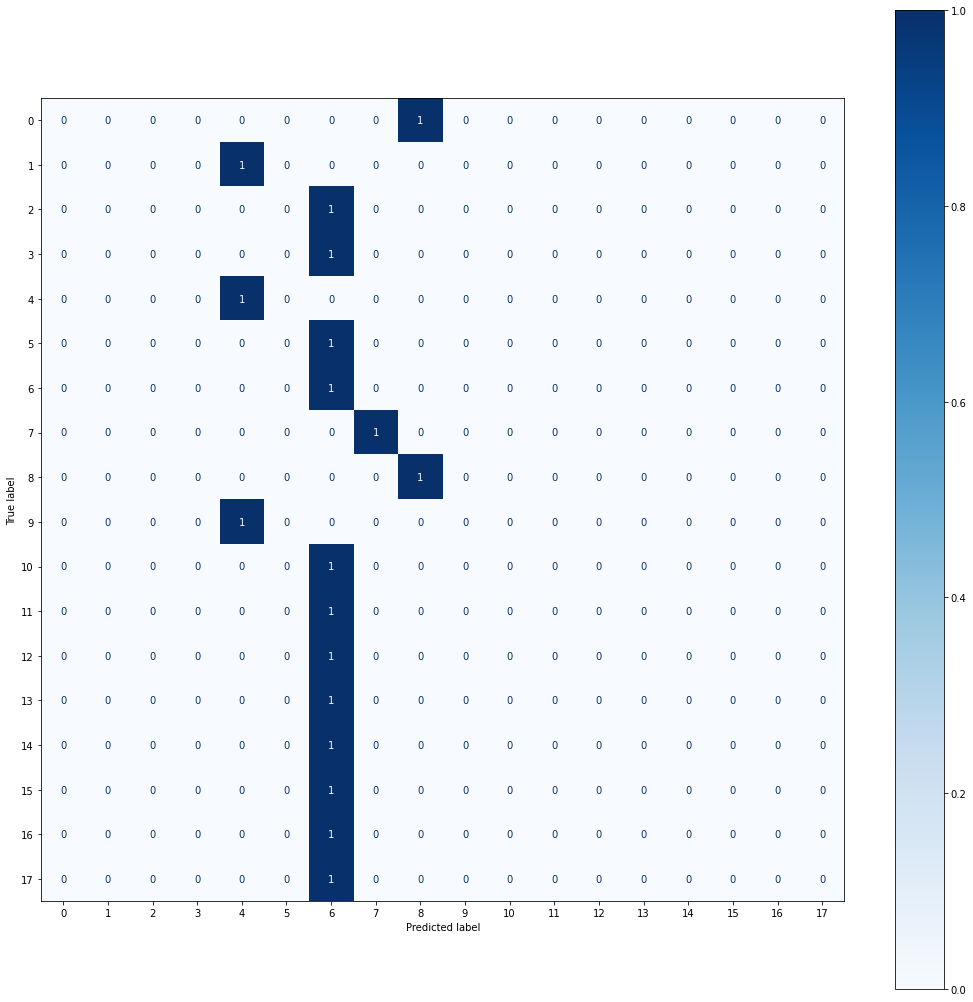

In [12]:
from sklearn import metrics

def plot_confusion_matrix(labels, pred_labels):

    fig = plt.figure(figsize=(18, 18))
    ax = fig.add_subplot(1, 1, 1)
    cm = metrics.confusion_matrix(labels, pred_labels)
    cm = metrics.ConfusionMatrixDisplay(cm, display_labels=range(18))
    cm.plot(values_format='d', cmap='Blues', ax=ax)
    
train_set_probabilities_for_classes = model.predict(X_train)
# class with a maximum probability is our predicted quality class
train_set_predicted_classes = np.argmax(train_set_probabilities_for_classes, axis = 1)
y_train_class = np.argmax(y_train, axis = 1)
confusion_matrix(y_train_class, train_set_predicted_classes)

plot_confusion_matrix(y_train_class, train_set_predicted_classes)